# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on several
datasets. As part of the practical you should read briefly the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT.

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier (NBC)

You should implement a Naïve Bayes Classifier from scartch using NumPy. To keep your code tidy,
we recommend implementing it as a class.
The classifier should be able to handle binary and continuous features.
To earn the bonus points, the classifier should be able to handle categorical features as well.
Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'])

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**.
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y \mid \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The **fit** function is to estimate all the parameters ($\theta$ and $\pi$) of the NBC, i.e., train the classifier. The **predict** function is to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability, i.e., make the prediction.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries.

In [1]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# used to upload folder to google colab if drive is not mounted
from zipfile import ZipFile
file_name = './datasets.zip'

try:
  with ZipFile(file_name, 'r') as zip_f:
    zip_f.extractall()
    print('Zip extracted!')
except FileNotFoundError as e:
    print('No zip file found!')

Zip extracted!


### Class-conditional distributions

Before implementing NBC, we first implement the class-conditional distributions $p(\mathbf{x} \mid y, \theta)$. Your implementation should have two functions: **estimate** and **get_log_probability**.

- The **estimate** function takes data as input and models the data using some distribution $p(x \mid \theta)$, where $\theta$ is the parameters of this distribution. The function estimates the parameters $\theta$ using maximum likelihood estimators (MLE).
For example, in the case of continuous features, we use the Gaussian distribution to model the data. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data.

- The **get_log_probability** function takes as input a new data point $x_{new}$ and returns the log of $p(x_{new} \mid \theta)$. For the Gaussian distribution, the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$.

For different types of features, you need to use different distributions.
You can import statistic libraries (e.g., `scipy.stats`) for the implementation of the distributions.

- For **continuous features**: Use Gaussian distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
- For **binary features**: Use Bernoulli distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html
- For **categorical features**: Use Multinoulli distribution (The multinoulli distribution is a special case of the multinomial distribution, where the number of trials is 1)
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html



**Implementation Issues:**
- The probabilities can be very small. To avoid underflow issues, you should compute the log of the probabilities. Read more: (Mur) Chapter 3.5.3 / Lecture Notes
- The variance for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6. This is to ensure that your code never encounters division by zero or
taking logarithms of 0 errors.
For this practical, please set the small value to 1e-6.
- Laplace/Additive smoothing: You want to ensure that the estimates for the parameter for the Bernoulli and Multinoulli random variables is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).
For this practical, please set alpha to 1.
- We will check the correctness of your implementation using the tests below.
- For simplicity, you can assume the data values for binary features are integers from {0,1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.


In [3]:
from scipy.stats import norm, bernoulli, multinomial

In [4]:
ALPHA = 1.0 # for additive smoothing


# smooth parameter for class 'c' in a 'd'-dimensional multinomial distribution
def get_smoothed_parameter(X, c, d):
    n = len(X)
    k = np.sum(X == c)
    return (k + ALPHA) / (n + ALPHA * d)


# Distribution for continuous features
class ContFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution
        # so that it best describes the input data X
        # The code below is just for compilation.
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        mu = np.mean(X)
        std = np.std(X) if np.std(X) != 0 else 1E-6
        self.p = (mu, std)
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_log_probability(self, X_new):
        # TODO: return the log of the density values for the input values X_new
        # The code below is just for compilation.
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        mu, std = self.p
        return norm.logpdf(X_new, loc=mu, scale=std)
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################


# Distribution for binary features
class BinFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Bernoulli distribution
        # so that it best describes the input data X
        # The code below is just for compilation.
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        # X is a vector with binary values
        p_smoothed = get_smoothed_parameter(X, c=1, d=2)
        self.p = p_smoothed
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # The code below is just for compilation.
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        return bernoulli.logpmf(X_new, p=self.p)
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################


# Distribution for categorical features
class CatFeatureParam:

    # we need to know the number of categories for the categorical feature
    def __init__(self, num_of_categories):
        self._num_of_categories = num_of_categories

    def estimate(self, X):
        # TODO: Estimate the parameters for the Multinoulli distribution
        # so that it best describes the input data X
        # The code below is just for compilation.
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        p_smoothed = [get_smoothed_parameter(X, c=i, d=self._num_of_categories) for i in range(self._num_of_categories)]
        self.p = p_smoothed
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # The code below is just for compilation.
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        return multinomial.logpmf(np.eye(self._num_of_categories)[X_new], n=1, p=self.p)  # use identity matrix to get probability for desired class labels (used as indices)
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

**Tests:**
    
We will use the code below to test the correctness of your code.

In [5]:
# continuous features

X = np.array([2.70508547,2.10499698,1.76019132,3.42016431,3.47037973,3.67435061,1.84749286,4.3388506,2.27818252,4.65165335])

param = ContFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3]))
print(probs)

[-5.64670664 -3.02757918 -1.44567455 -0.90099277]


In [6]:
# binary features

X = np.array([0,0,1,1,0,1,0,1,1,1])

param = BinFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1]))
print(probs)

[-0.87546874 -0.5389965 ]


In [7]:
# categorical features (bonus task)

X = np.array([0,6,5,4,0,6,6,4,1,1,2,3,8,8,1,6,4,9,0,2,2,3,8,0,2])

param = CatFeatureParam(num_of_categories=10)
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3,4,5,6,7,8,9]))
print(probs)

[-1.94591015 -2.1690537  -1.94591015 -2.45673577 -2.1690537  -2.86220088
 -1.94591015 -3.55534806 -2.1690537  -2.86220088]


### Implement NBC

We are now ready to implement NBC. We follow the structure of models in scikit-learn. We implement NBC as a class with functions **init**, **fit** and **predict**.
The **init** function takes as input the types of features and initialise the classifier. The **fit** function takes the training data as input and estimates the parameters. The **predict** function predicts the label for the input data.

**Implementation Issues:**
- You should use matrix operations rather than loops. In general, loops over classes or features are OK, but loops over the rows of data are not a good idea.
- The probabilities can be very small. To avoid underflow issues, you should do the calculations in log space. Read more: (Mur) Chapter 3.5.3 / Lecture Note
- For simplicity, you can assume the data values for binary features are integers from {0, 1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.

In [8]:
# Your task is to implement the three functions of NBC.

class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['b', 'r', 'c']
    #   num_of_categories: the array of total categoies per feature (precomputed)
    def __init__(self, feature_types=[], num_of_categories=[]):
        # TODO:
        # The code below is just for compilation.
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        self.feature_types = feature_types
        self.num_of_categories = num_of_categories
        self.class_distribution = None
        self.feature_distributions = None
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################


    # The function uses the input data to estimate all the parameters of the NBC
    def fit(self, X, y):
        # TODO:
        # The code below is just for compilation.
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        classes, counts = np.unique(y, return_counts=True)
        self.class_distribution = counts / len(y)
        self.feature_distributions = []

        for idx, feature_type in enumerate(self.feature_types):  # for every feature estimate parameters for each class
            feature_column = X[:, idx]
            feature_distribution_per_class = []
            for c in classes:
                rows_of_class = np.where(y==c)[0]
                feature_column_of_class = feature_column[rows_of_class]
                if feature_type == 'r':
                    param = ContFeatureParam()
                elif feature_type == 'b':
                    param = BinFeatureParam()
                elif feature_type == 'c':
                    param = CatFeatureParam(num_of_categories=self.num_of_categories[idx])
                param.estimate(feature_column_of_class)
                feature_distribution_per_class.append(param)
            self.feature_distributions.append(feature_distribution_per_class)

        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################


    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        # TODO:
        # The code below is just for compilation.
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        y_hat = []
        for c, c_distribution in enumerate(self.class_distribution):  # for each class compute log probability for every feature, return most likely class (max of probabilities of a feature)
            total_probabilities = np.zeros(X.shape[0])
            for idx in range(len(self.feature_types)):
                param = self.feature_distributions[idx][c]
                feature_column = X[:, idx]
                log_probabilities = param.get_log_probability(feature_column)
                total_probabilities += log_probabilities
            total_probabilities += np.log(c_distribution)
            y_hat.append(total_probabilities)

        return np.array(y_hat).argmax(axis=0)

        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################


**Tests**

We will use the code below to check your code.

In [20]:
from sklearn.datasets import load_iris
import pandas as pd

In [9]:
# All features of the iris dataset are continuous.
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 90%
print(yhat)

Accuracy: 0.9333333333333333
[2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [10]:
# All features of this dataset are binary
data = pd.read_csv('./datasets/binary_test.csv', header=None)
data = data.to_numpy()

X = data[:,1:]
y = data[:,0]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['b'] * 16)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 85%
print(yhat)

Accuracy: 0.8723404255319149
[1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 0
 0 0 1 0 0 0 0 1 1 0]


In [11]:
# All features of this dataset are categorical (bonus task)

data = pd.read_csv('./datasets/categorical_test.csv', header=None)
data = data.to_numpy()

X = data[:,:-1]
y = data[:,-1]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]

num_of_categories = np.max(X, axis=0) + 1  # precompute size of domains

nbc = NBC(feature_types=['c'] * 9, num_of_categories=num_of_categories)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 65%
print(yhat)

Accuracy: 0.6896551724137931
[0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]


## Logistic Regression

For logistic regression, you should use the implementation in scikit-learn. Add the following
line to import the LR model.

In [12]:
from sklearn.linear_model import LogisticRegression

Check the scikit-learn documentation for the Logistic Regression model:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

The experiment is to compare the classification error of the NBC and LR trained on increasingly larger training datasets.
Since the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a function of the size of the training data.
We have written for you the function for making the plots for the experiments.

In [14]:
# fit model to training data and predict y_hat using test data
def fit_and_predict(X_train, y_train, X_test, model):
    model.fit(X_train, y_train)
    return model.predict(X_test)


# compute error on the test set
def get_error(X_train, y_train, X_test, y_test, model):
    y_hat = fit_and_predict(X_train, y_train, X_test, model)
    test_accuracy = np.mean(y_hat == y_test)
    return 1 - test_accuracy


# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps.
# outputs:
#   the arrays of the test errors across the runs of the two classifiers
def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10):
    # The code below is just for compilation.
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    tst_errs_nbc = []
    tst_errs_lr = []
    N, _ = X.shape
    train_size = int(0.8 * N)
    percentage_indices = (np.linspace(0, 1, num_splits+1)[1:] * train_size).astype(int)  # compute indices which correspond to num_splits percentages of data

    for _ in range(num_runs):
        shuffler = np.random.permutation(N)
        X_test = X[shuffler[train_size:]]
        y_test = y[shuffler[train_size:]]
        while 0 in np.max(X_test, axis=0):  # covers edge case where all samples belong to same class for a specific feature (required for LinearRegression)
            shuffler = np.random.permutation(N)
            X_test = X[shuffler[train_size:]]
            y_test = y[shuffler[train_size:]]
        curr_tst_errs_nbc = []
        curr_tst_errs_lr = []

        for idx in percentage_indices:  # increase considered data for each iteration
            X_train = X[shuffler[:idx]]
            y_train = y[shuffler[:idx]]
            curr_tst_errs_nbc.append(get_error(X_train, y_train, X_test, y_test, model=nbc))
            curr_tst_errs_lr.append(get_error(X_train, y_train, X_test, y_test, model=lr))

        tst_errs_nbc.append(curr_tst_errs_nbc)
        tst_errs_lr.append(curr_tst_errs_lr)


    return np.mean(tst_errs_nbc, axis=0), np.mean(tst_errs_lr, axis=0)  # compute average errors for every split
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

In [15]:
def makePlot(nbc_perf, lr_perf, title=None, num_splits=10):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * (100/num_splits) for i in range(num_splits)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')

    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. Prepare the data for the two classifiers, e.g., handle missing values and the categorical data. When you handle the categorical data, you should check whether the data is ordinal or not. If the data is ordinal, you should encode the data as integers. If the data is not ordinal, you should encode the data as one-hot vectors.
2. Show the first 5 rows of the prepared data
3. Compare the two classifiers on the dataset and generate the plots

The grading will be based on whether the data is correctly prepared and the plots are generated without errors. The grading will not be based on the performance of the classifiers and whether the plots are the same as in the paper.

In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   species  
0        0  
1        0  
2        0  
3        0  
4        0  


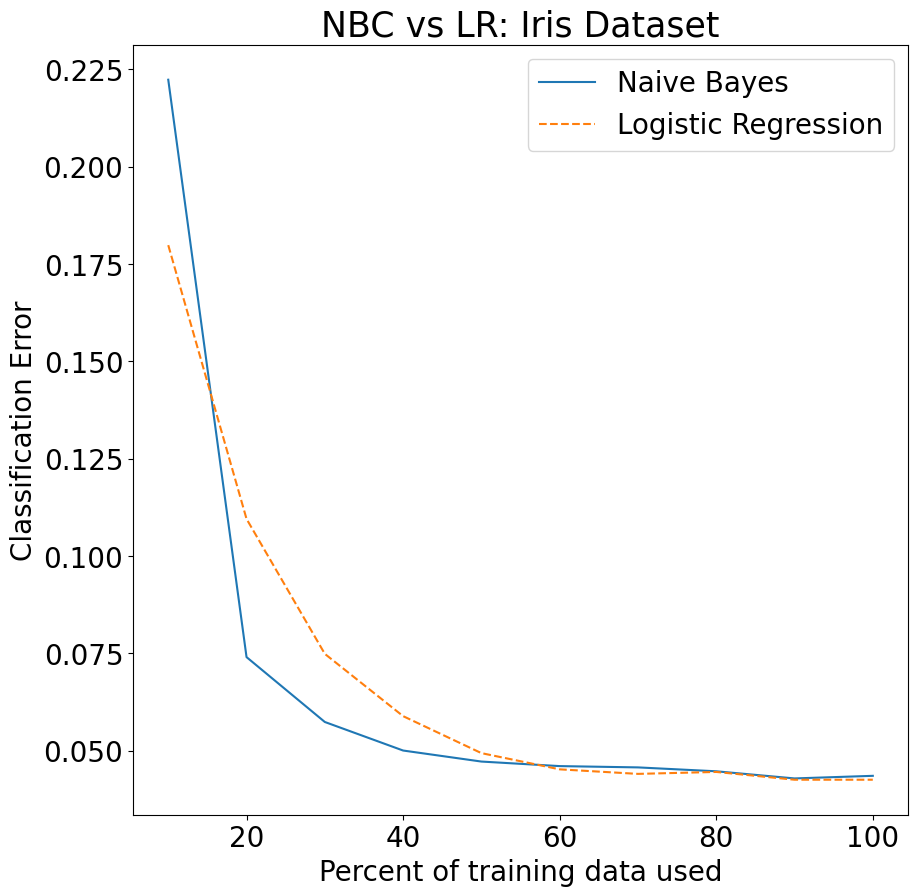

In [21]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
iris = load_iris()
iris_data = np.c_[iris['data'], iris['target']]  # convert data into pandas dataframe to show first 5 rows (no NaN values)
iris_data = pd.DataFrame(iris_data, columns=np.append(iris['feature_names'], 'species'))
iris_data['species'] = iris_data['species'].astype('int')
print(iris_data.head())

X, y = iris_data.drop('species', axis=1).values, iris_data['species'].values

std_scaler = StandardScaler()  # standardize values for LinearRegression (enables convergence)
X_std = std_scaler.fit_transform(X)

nbc_iris = NBC(feature_types=['r'] * X.shape[1])
lr_iris = LogisticRegression()

test_errs_nbc, test_errs_lr = compareNBCvsLR(nbc_iris, lr_iris, X_std, y)
makePlot(nbc_perf=test_errs_nbc, lr_perf=test_errs_lr, title='NBC vs LR: Iris Dataset')
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records

The logistic regression line meets the naive bayes line early in the plot.

    label  handicapped-infants  water-project-cost-sharing  \
5       0                    0                           1   
8       1                    0                           1   
19      0                    1                           1   
23      0                    1                           1   
25      0                    1                           0   

    adoption-of-the-budget-resolution  physician-fee-freeze  el-salvador-aid  \
5                                   1                     0                1   
8                                   0                     1                1   
19                                  1                     0                0   
23                                  1                     0                0   
25                                  1                     0                0   

    religious-groups-in-schools  anti-satellite-test-ban  \
5                             1                        0   
8                         

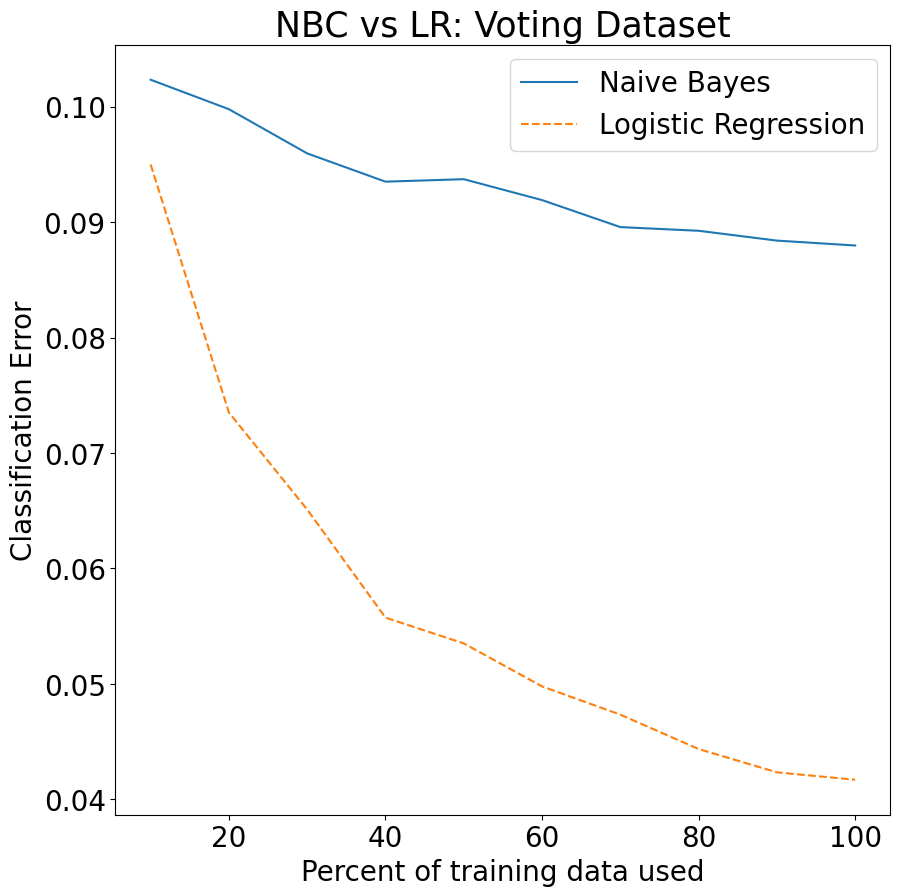

In [22]:
# load the dataset
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
voting = pd.read_csv('./datasets/voting.csv')

ordinal_encoder = OrdinalEncoder()  # used to encode 'no': 0, 'yes': 1
voting_encoded = pd.DataFrame(ordinal_encoder.fit_transform(voting), columns=voting.columns)

# Option A: Drop rows with NaN values
voting_no_nan = voting_encoded.dropna()

# Option B: Replace NaN with median
# voting_no_nan = voting_encoded.fillna(voting_encoded.median())

voting_data = pd.DataFrame(voting_no_nan, columns=voting_no_nan.columns, dtype=int)
print(voting_data.head())

X, y = voting_data.drop('label', axis=1).values, voting_data['label'].values

nbc_voting = NBC(feature_types=['b'] * X.shape[1])
lr_voting = LogisticRegression()

test_errs_nbc, test_errs_lr = compareNBCvsLR(nbc_voting, lr_voting, X, y)
makePlot(nbc_perf=test_errs_nbc, lr_perf=test_errs_lr, title='NBC vs LR: Voting Dataset')
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

**Dataset 3: Breast Cancer Dataset (Bonus Tasks)**

https://archive.ics.uci.edu/ml/datasets/breast+cancer

The dataset has continues, binary and categorical features. It also has missing values.

Hints: You can precompute the size of the domains of the categorical features.

   Class  age  menopause  tumor-size  inv-nodes  node-caps  deg-malig  breast  \
0      0    1          2           5          0          0          2       0   
1      0    2          2           3          0          0          1       1   
2      0    2          2           3          0          0          1       0   
3      0    4          0           2          0          0          1       1   
4      0    2          2           0          0          0          1       1   

   breast-quad  irradiat  
0            1         0  
1            4         0  
2            1         0  
3            2         0  
4            3         0  


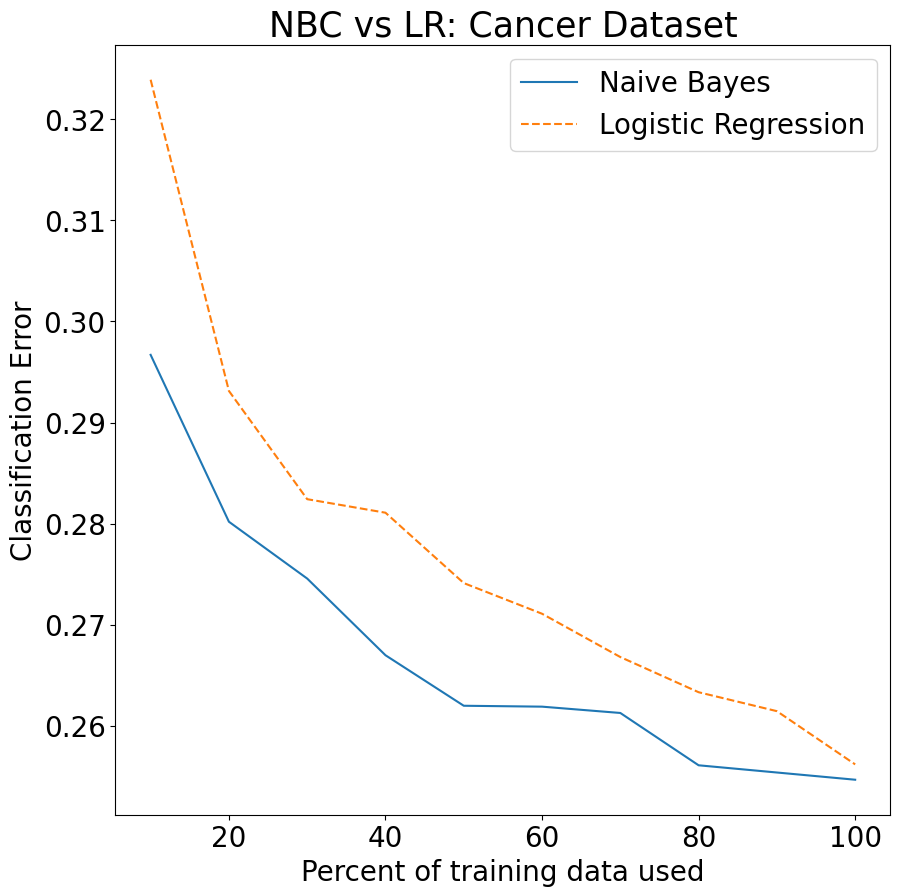

In [23]:
# load the dataset
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
cancer = pd.read_csv('./datasets/breast-cancer.csv')
cancer = cancer.replace('?', np.NaN)  # replace '?' to enable NaN-handling

ordinal_encoder = OrdinalEncoder()  # used to encode ordinally
cancer_encoded = pd.DataFrame(ordinal_encoder.fit_transform(cancer), columns=cancer.columns)

# Option A: Drop rows with NaN values
cancer_no_nan = cancer_encoded.dropna()

# Option B: Replace NaN with median
# cancer_no_nan = cancer_encoded.fillna(cancer_encoded.median())

cancer_data = pd.DataFrame(cancer_no_nan, columns=cancer_no_nan.columns, dtype=int)
print(cancer_data.head())

X, y = cancer_data.drop('Class', axis=1).values, cancer_data['Class'].values

cancer_num_of_categories = np.max(X, axis=0) + 1  # precompute the size of the domains

nbc_cancer = NBC(feature_types=['c'] * 4 + ['b'] + (['c'] + ['b']) * 2, num_of_categories=cancer_num_of_categories)  # also works with ['c'] * X.shape[1] since 'b' is a trivial case of 'c'
lr_cancer = LogisticRegression()

test_errs_nbc, test_errs_lr = compareNBCvsLR(nbc_cancer, lr_cancer, X, y)
makePlot(nbc_perf=test_errs_nbc, lr_perf=test_errs_lr, title='NBC vs LR: Cancer Dataset')
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################